# Multifractal Detrended Moving Average (MF-DMA) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_9016\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

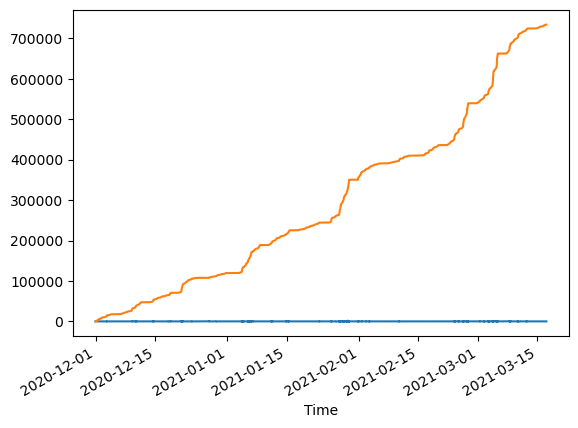

In [3]:
n_sample = 60 * 24 * 22 * 3 # sample is 3-month-equivalent dataset

cs = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
cs['cum_sum'] = cs['log_ret_sq']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret_sq'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret_sq,cum_sum
Time,,
2020-12-01 00:01:00,3.733753,3.733753
2020-12-01 00:02:00,0.634167,4.367920
2020-12-01 00:03:00,1.144941,5.512860
2020-12-01 00:04:00,0.074901,5.587761
2020-12-01 00:05:00,2.233315,7.821076
...,...,...
2021-03-17 02:25:00,1.518706,734155.463935
2021-03-17 02:26:00,0.286569,734155.750504
2021-03-17 02:27:00,0.573778,734156.324282


## In the for-loop:
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [5]:
# Define parameters
lags = np.unique(np.logspace(0.5, 3, 50).astype(int))
qs = list(np.linspace(-10, 10, num=41, endpoint=True)) # q is in [-10, 10] excluding 0
qs.remove(0.)
total_epoch = len(lags) * len(qs)
len_total = len(cs['cum_sum'])

# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    F_summary_columns.append('q_'+str(q))

F_summary_index = []
for l in lags:
    F_summary_index.append('n_'+str(l))

F_summary = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)

In [6]:
print(f'Total epochs is {total_epoch}, estimated time is {int(total_epoch/75)} min') # speed is ~75 epochs/min
starttime_total = time.time()

epoch = 0
for lag in lags:
    mean_temp = []
    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    mean_temp.reverse()

    # Detrend
    diff_temp_subtractor = cs['cum_sum'][:lag-2:-1].values
    diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)

    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // lag, lag))).T

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0)) 

    for q in qs:
        # Calculate the qth order fluctuation function
        F_temp =  ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
        F_summary.loc[str('n_'+str(lag))][str('q_'+str(q))] = F_temp
        epoch += 1
        
    print(f'Epoch {epoch} is done')
        
endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'Total time spent is {int((endtime_total-starttime_total)//60)} min {int((endtime_total-starttime_total) % 60)} sec(s)')

Total epochs is 1880, estimated time is 25 min
Epoch 40 is done
Epoch 80 is done
Epoch 120 is done
Epoch 160 is done
Epoch 200 is done
Epoch 240 is done
Epoch 280 is done
Epoch 320 is done
Epoch 360 is done
Epoch 400 is done
Epoch 440 is done
Epoch 480 is done
Epoch 520 is done
Epoch 560 is done
Epoch 600 is done
Epoch 640 is done
Epoch 680 is done
Epoch 720 is done
Epoch 760 is done
Epoch 800 is done
Epoch 840 is done
Epoch 880 is done
Epoch 920 is done
Epoch 960 is done
Epoch 1000 is done
Epoch 1040 is done
Epoch 1080 is done
Epoch 1120 is done
Epoch 1160 is done
Epoch 1200 is done
Epoch 1240 is done
Epoch 1280 is done
Epoch 1320 is done
Epoch 1360 is done
Epoch 1400 is done
Epoch 1440 is done
Epoch 1480 is done
Epoch 1520 is done
Epoch 1560 is done
Epoch 1600 is done
Epoch 1640 is done
Epoch 1680 is done
Epoch 1720 is done
Epoch 1760 is done
Epoch 1800 is done
Epoch 1840 is done
Epoch 1880 is done
Total time spent is 9 min 32 sec(s)


In [7]:
F_summary

,q_-10.0,q_-9.5,q_-9.0,q_-8.5,q_-8.0,q_-7.5,q_-7.0,q_-6.5,q_-6.0,q_-5.5,...,q_5.5,q_6.0,q_6.5,q_7.0,q_7.5,q_8.0,q_8.5,q_9.0,q_9.5,q_10.0
n_3,15.671339,15.762216,15.863808,15.978128,16.107723,16.255867,16.426845,16.626363,16.862198,17.145229,...,11.498592,11.691595,11.857434,12.001452,12.127682,12.239222,12.338492,12.427407,12.507505,12.580035
n_4,20.414658,20.564154,20.731545,20.920241,21.134579,21.380151,21.664301,21.996861,22.391307,22.866598,...,13.812448,14.105639,14.35858,14.578993,14.772753,14.944404,15.097517,15.234933,15.358944,15.471418
n_5,24.242208,24.448429,24.679622,24.940602,25.237505,25.57827,25.973353,26.436808,26.987967,27.654169,...,15.402447,15.782659,16.111698,16.399187,16.652489,16.877337,17.078251,17.258849,17.422055,17.570259
n_6,27.049781,27.306076,27.593697,27.918742,28.288996,28.714558,29.208758,29.789568,30.481793,31.320644,...,16.325504,16.774777,17.164575,17.505889,17.807179,18.075059,18.314768,18.53051,18.725696,18.903121
n_7,30.207282,30.518244,30.867513,31.262604,31.71313,32.23158,32.83448,33.544161,34.391532,35.42061,...,17.456118,17.978447,18.432607,18.831008,19.183247,19.496857,19.777826,20.030974,20.26022,20.468784
n_8,33.143177,33.507902,33.917862,34.38199,34.911731,35.521977,36.232474,37.069955,38.071513,39.290116,...,18.445352,19.035756,19.550065,20.001947,20.402018,20.758639,21.078478,21.366914,21.628332,21.866342
n_9,37.044903,37.47579,37.960433,38.509514,39.136729,39.859932,40.702827,41.697571,42.888873,44.340731,...,19.943693,20.61882,21.2079,21.726204,22.185636,22.595601,22.963622,23.295781,23.597046,23.871514
n_10,39.063572,39.539859,40.07588,40.683566,41.378235,42.179875,43.11507,44.219936,45.544782,47.161775,...,20.415206,21.140015,21.773378,22.331342,22.826463,23.268691,23.666002,24.024859,24.350551,24.647448
n_11,43.68249,44.237279,44.861978,45.570617,46.381224,47.317357,48.410382,49.702975,51.254685,53.151099,...,22.224091,23.046378,23.765878,24.400445,24.964091,25.467953,25.920975,26.330422,26.702249,27.04138
n_12,45.483257,46.082014,46.75655,47.522133,48.398409,49.41107,50.594368,51.994968,53.678079,55.737592,...,22.579725,23.446061,24.205025,24.875091,25.470801,26.003737,26.483229,26.91686,27.310862,27.670391


## 6. Calculate Hurst exponent

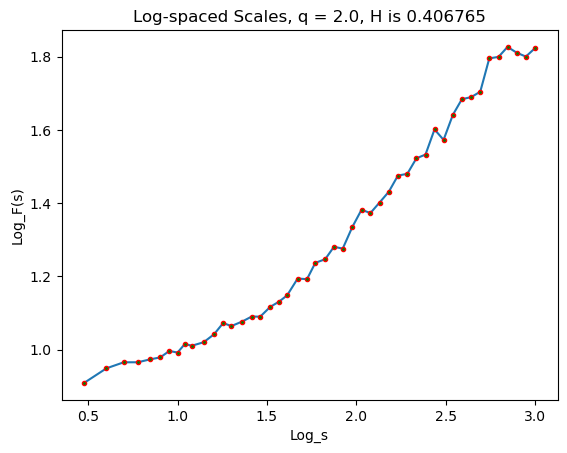

In [9]:
# Log-log plot and calculate H
log10_lag = np.log10(lags)
log10_F = np.log10(np.array(F_summary['q_2.0']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green") 
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title('Log-spaced Scales, q = 2.0, H is '+ f'{hurst_hat:2f}')
plt.show()